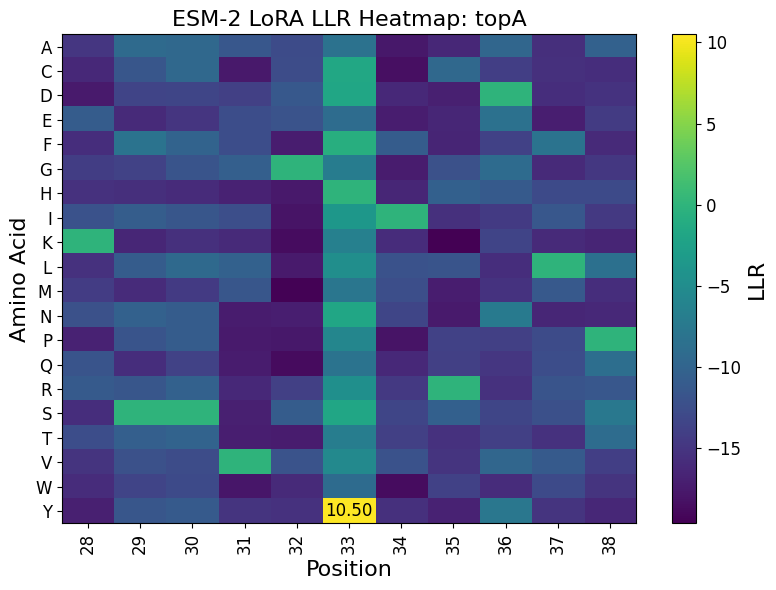

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_centered_heatmap(csv_file, mutated_pos, window_size=5, figsize=(8, 6), cmap="viridis"):
    """
    Load LLR data from CSV, center the heatmap around mutated_pos ± window_size, annotate 
    only the highest LLR cell, and plot with increased font sizes.
    """
    # Load data
    df = pd.read_csv(csv_file, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)
    
    # Find center window
    cols = df.columns.tolist()
    if mutated_pos not in cols:
        raise ValueError(f"{mutated_pos} not in CSV columns.")
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    
    # Compute max LLR cell
    values = sub_df.values
    max_i, max_j = np.unravel_index(np.nanargmax(values), values.shape)
    max_val = values[max_i, max_j]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(values, aspect='auto', cmap=cmap)
    
    # Annotate only the max cell
    ax.text(max_j, max_i, f"{max_val:.2f}", ha='center', va='center',
             fontsize=12, color='black')
    
    # Labels and ticks
    ax.set_xticks(range(values.shape[1]))
    ax.set_xticklabels(sub_df.columns, rotation=90, fontsize=12)
    ax.set_yticks(range(values.shape[0]))
    ax.set_yticklabels(sub_df.index, fontsize=12)
    ax.set_xlabel("Position", fontsize=16)
    ax.set_ylabel("Amino Acid", fontsize=16)
    ax.set_title(f"ESM-2 LoRA LLR Heatmap: topA", fontsize=16)
    
    # Colorbar
    cbar = plt.colorbar(cax, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("LLR", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Usage example (uncomment and update paths):
# plot_centered_heatmap("topA_llr_30-40.csv", mutated_pos=33, window_size=5)

# Example usage:
csv_file = "topA_llr_esm2_finetuned_corrected.csv"  # replace with your CSV path
mutated_pos = 33                 # the mutation position to center
window_size = 5              # number of positions on each side
plot_centered_heatmap(csv_file, mutated_pos, window_size)

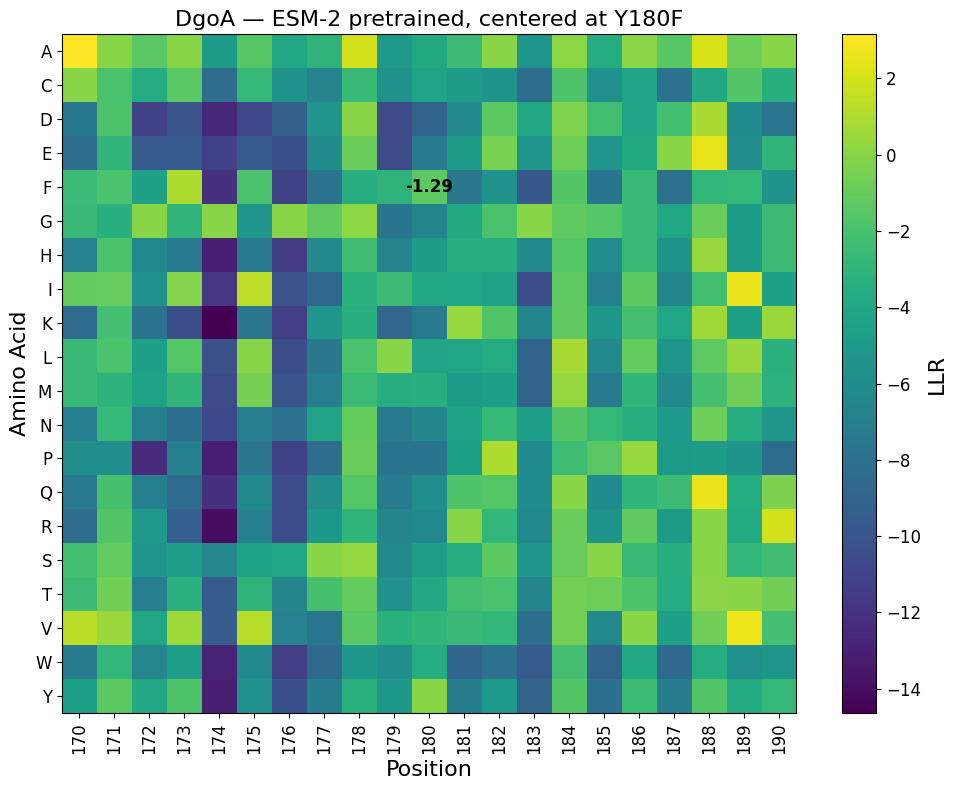

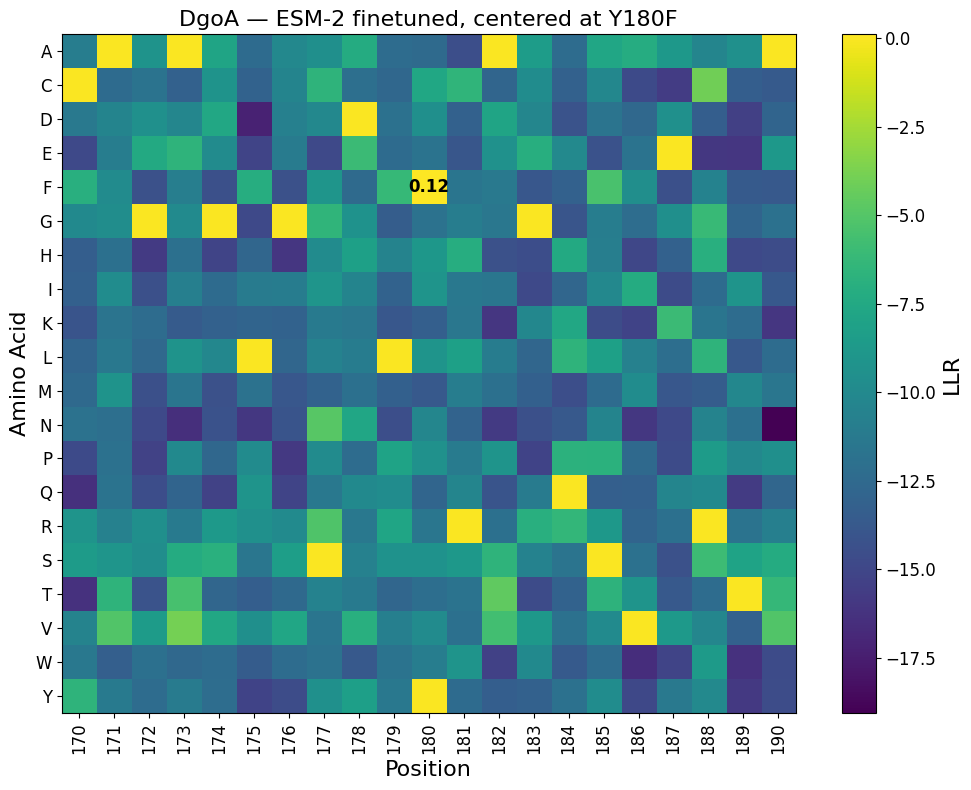

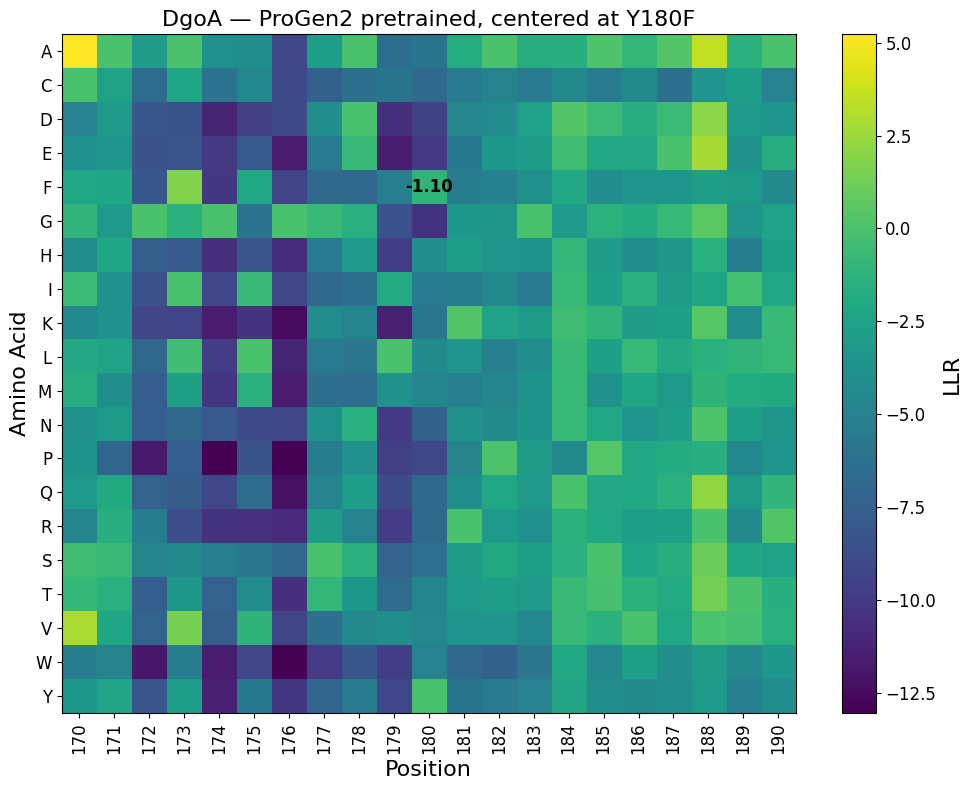

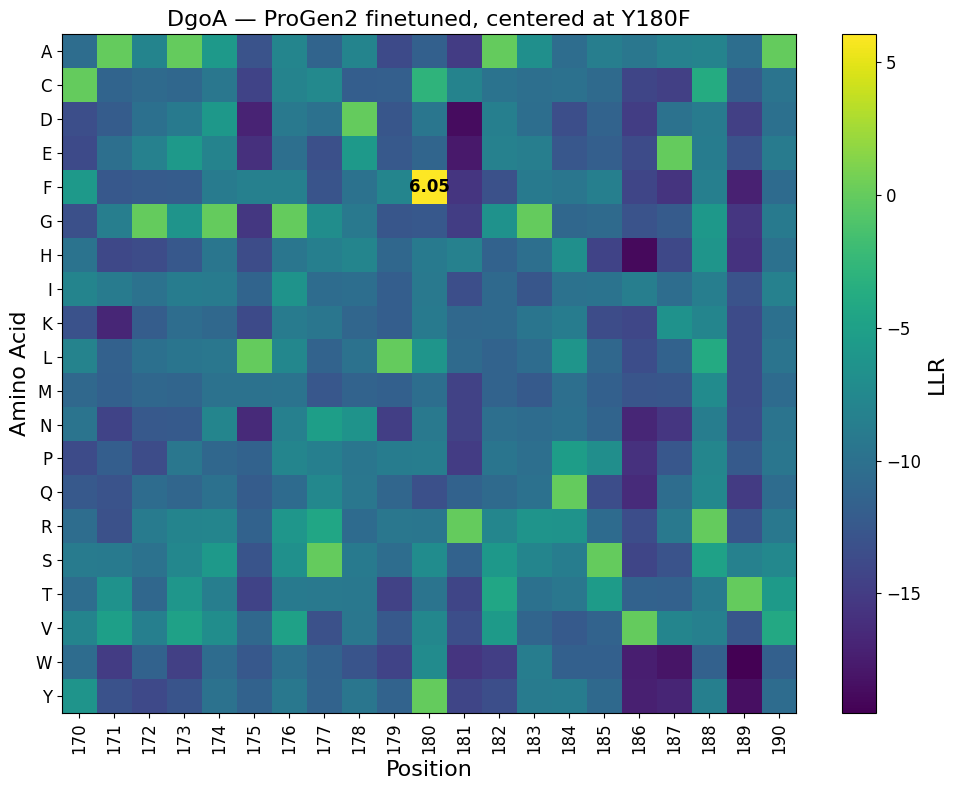

In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_centered_heatmap(csv_file, mutated_pos, mutated_residue, window_size=5, figsize=(8, 6), cmap="viridis", title=None, dynamic_text_color=False):
    """
    Load LLR data from CSV, center the heatmap around mutated_pos ± window_size,
    annotate only the cell corresponding to the mutation, and adjust text color
    for dark backgrounds if dynamic_text_color is True.
    """
    # Load & sort
    df = pd.read_csv(csv_file, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)
    
    # Center window
    cols = df.columns.tolist()
    if mutated_pos not in cols:
        raise ValueError(f"{mutated_pos} not in {csv_file} columns.")
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    
    # Locate mutation cell
    col_labels = sub_df.columns.tolist()
    row_labels = sub_df.index.tolist()
    j = col_labels.index(mutated_pos)
    if mutated_residue not in row_labels:
        raise ValueError(f"Residue {mutated_residue} not in rows.")
    i = row_labels.index(mutated_residue)
    val = sub_df.iloc[i, j]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(sub_df.values, aspect='auto', cmap=cmap)
    
    # Determine text color if needed
    text_color = 'black'
    if dynamic_text_color:
        norm = Normalize(vmin=np.nanmin(sub_df.values), vmax=np.nanmax(sub_df.values))
        rgba = plt.get_cmap(cmap)(norm(val))
        lum = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        if lum < 0.5:
            text_color = 'white'
    
    # Annotate mutation cell
    ax.text(j, i, f"{val:.2f}", ha='center', va='center',
            fontsize=12, fontweight='bold', color=text_color)
    
    # Labels
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=12)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.set_xlabel("Position", fontsize=16)
    ax.set_ylabel("Amino Acid", fontsize=16)
    ax.set_title(title, fontsize=16)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("LLR", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Map genes to their mutation strings
gene_mutation = {
    "DgoA": ["F33I", "D58N", "A75V", "Q72H", "V85A", "V154F", "Y180F"]
}

# Loop through each full-sequence CSV and plot
for csv_file in glob.glob("*_full_sequence.csv"):
    # filename format: gene_model_status_full_sequence.csv
    parts = csv_file.replace(".csv", "").split("_")
    gene, model_family, status = parts[0], parts[1], parts[2]
    
    for gene, mutation_list in gene_mutation.items():
        for mut in mutation_list:
            if not mut:
                continue
            mutated_pos = int(mut[1:-1])  # this will now work properly
            mutated_residue = mut[-1]
    
    # Build title with model info
    model_type = "ESM‑2" if "esm" in model_family.lower() else "ProGen2"
    status_text = "pretrained" if "pretrained" in status.lower() else "finetuned"
    title = f"{gene} — {model_type} {status_text}, centered at {mut}"
    
    # Only apply dynamic text color for pretrained plots
    dynamic_color = (status_text == "pretrained")
    
    # Plot centered heatmap
    plot_centered_heatmap(
        csv_file,
        mutated_pos=mutated_pos,
        mutated_residue=mutated_residue,
        window_size=10,
        figsize=(10, 8),
        cmap="viridis",
        title=title,
        dynamic_text_color=dynamic_color
    )


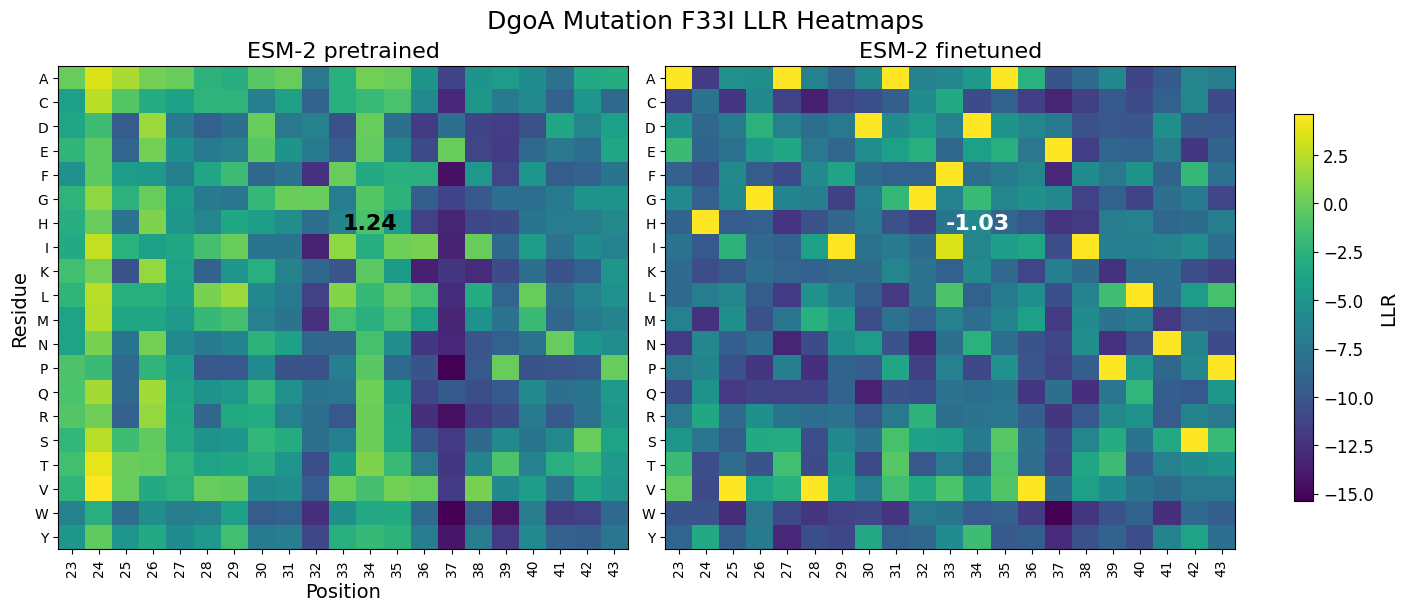

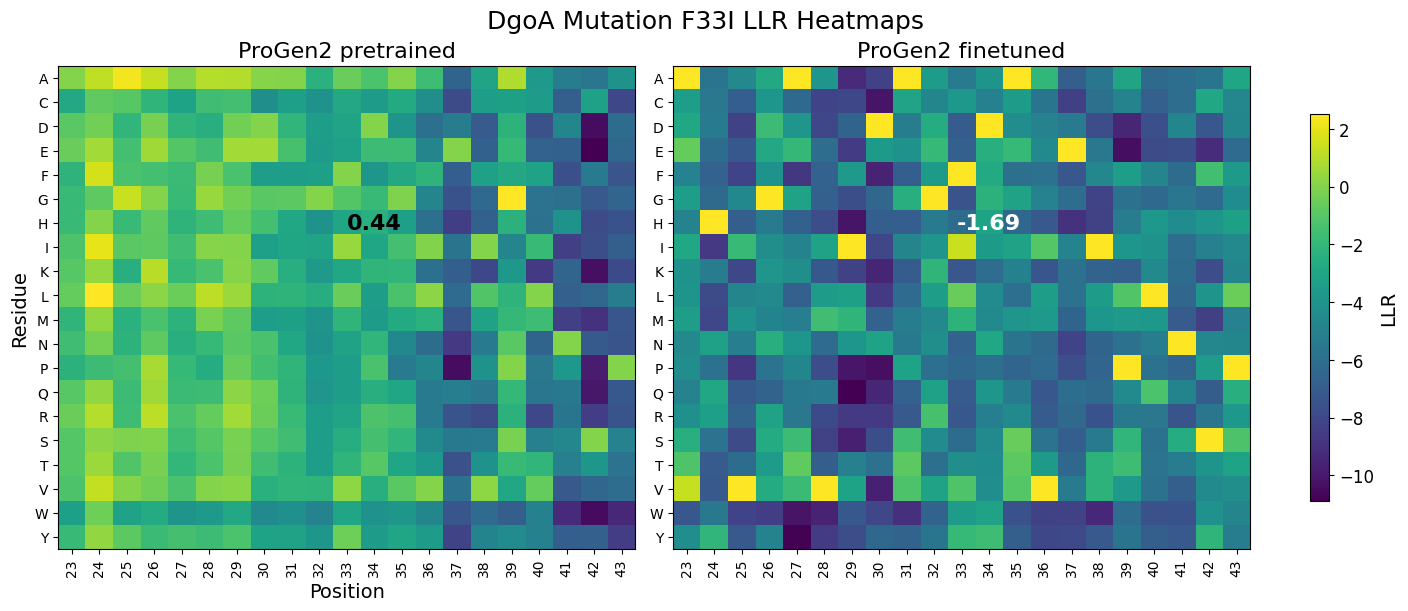

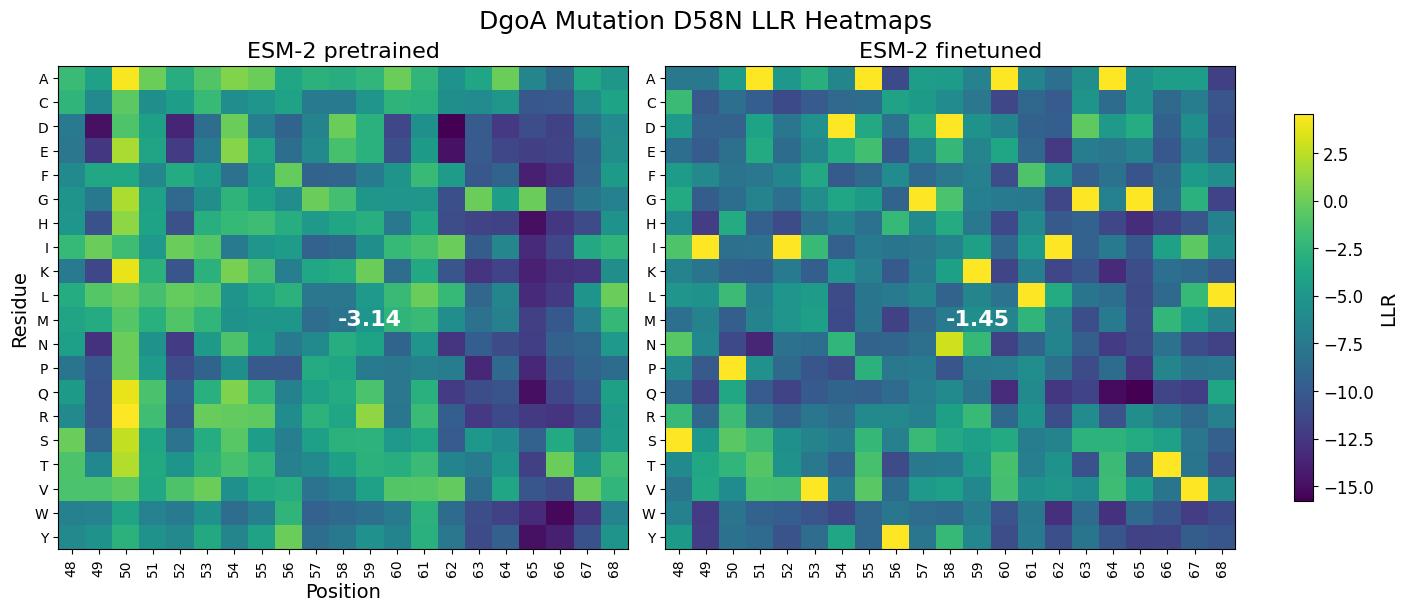

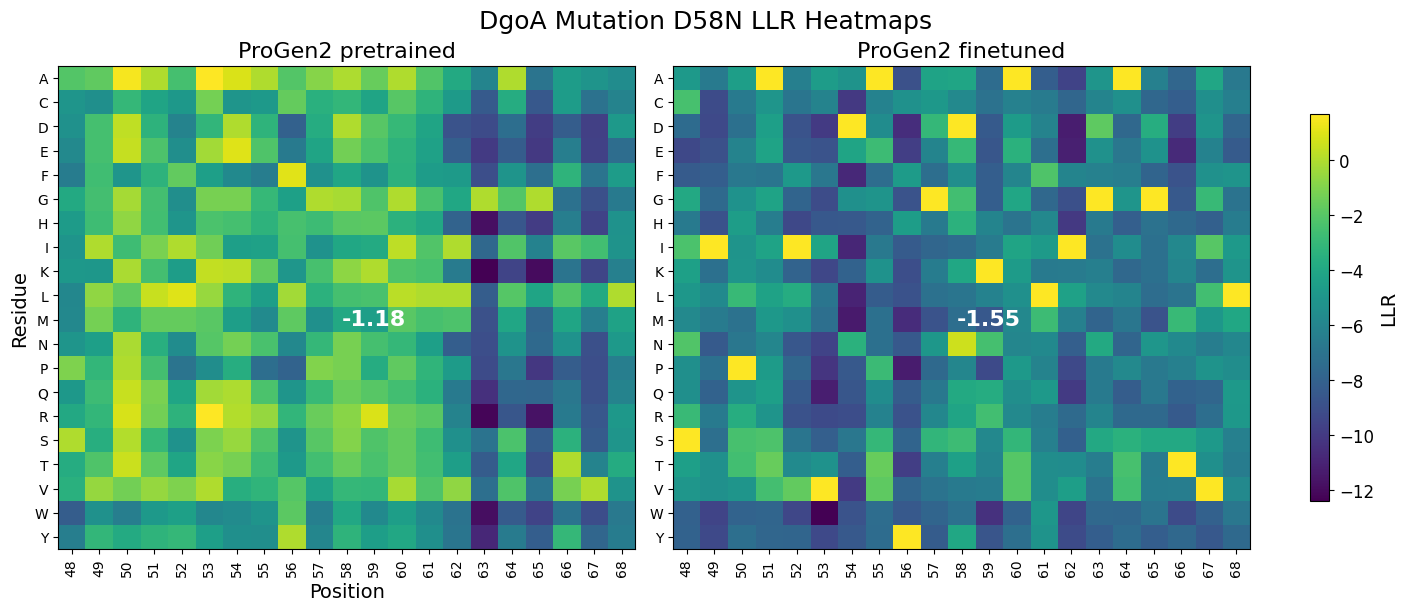

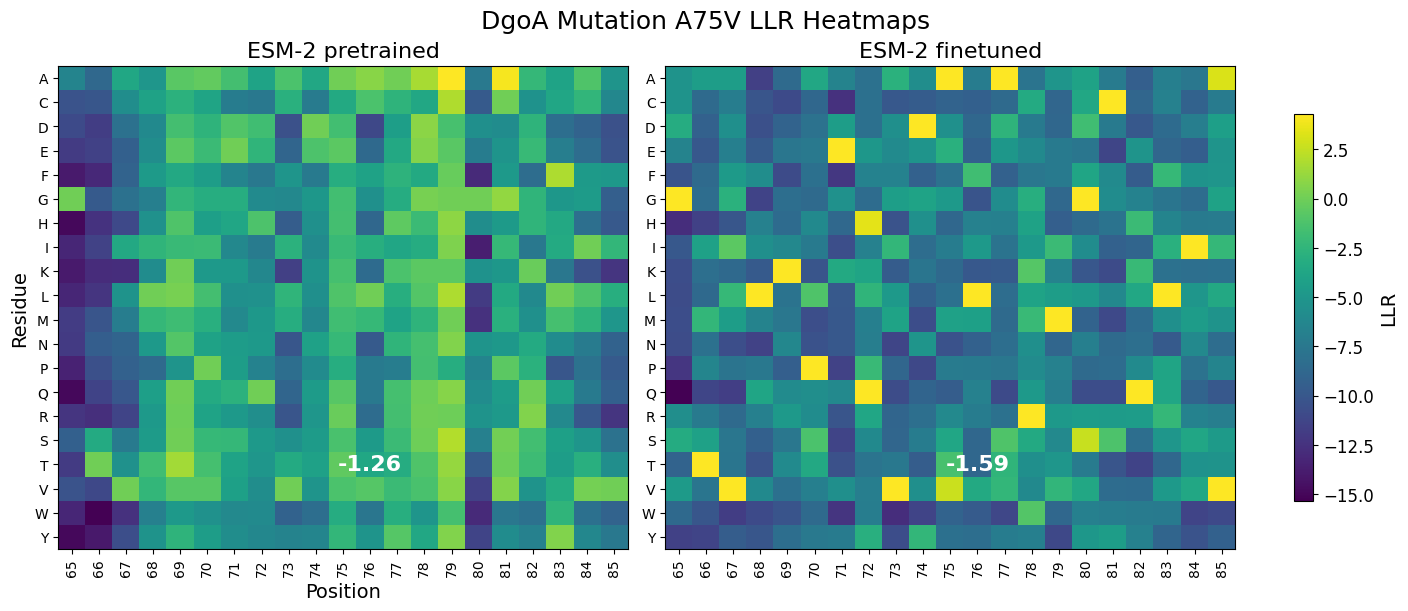

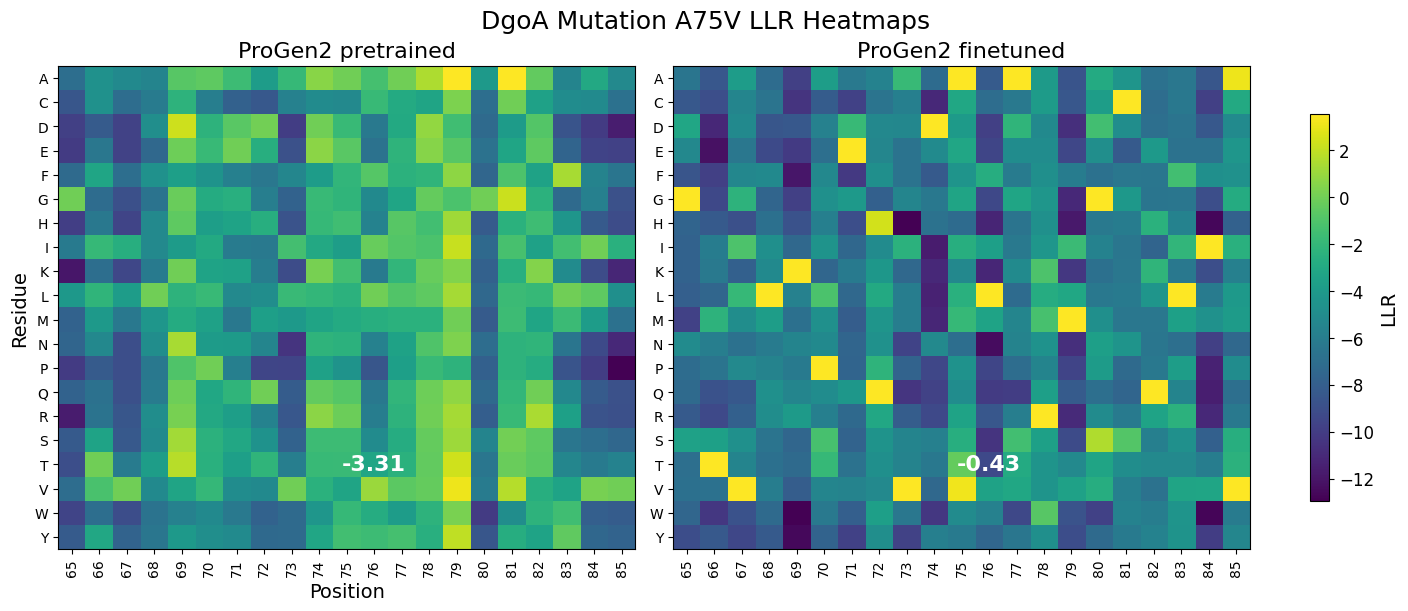

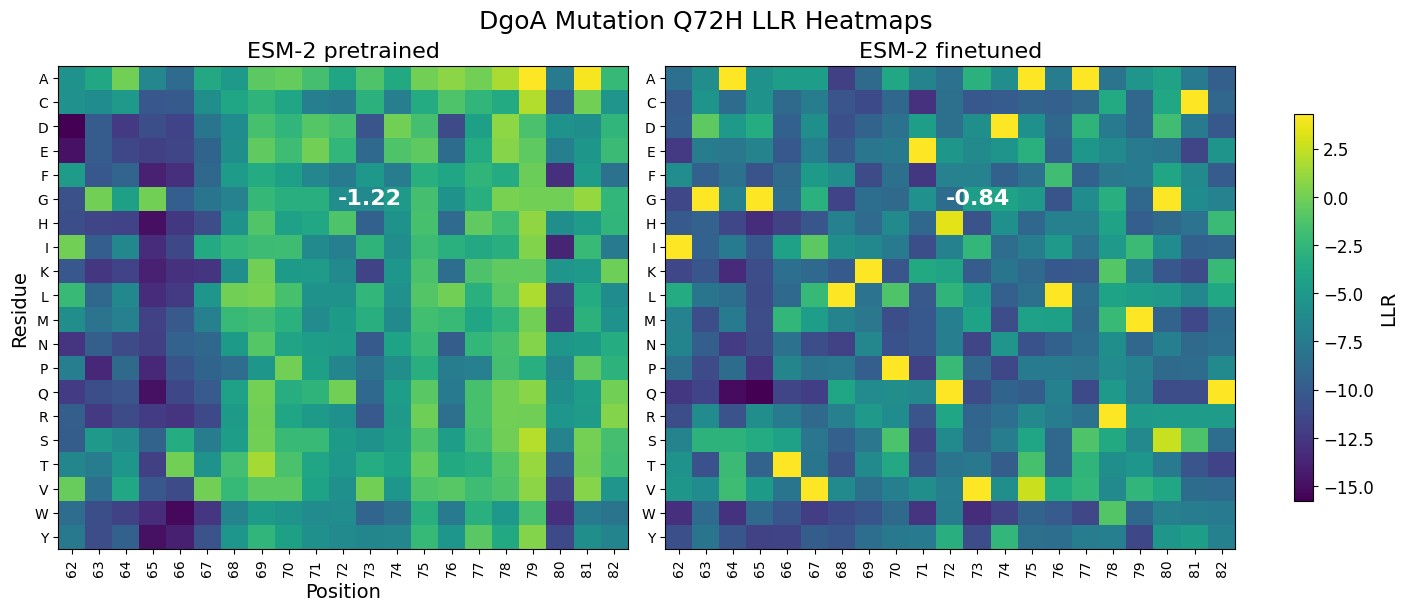

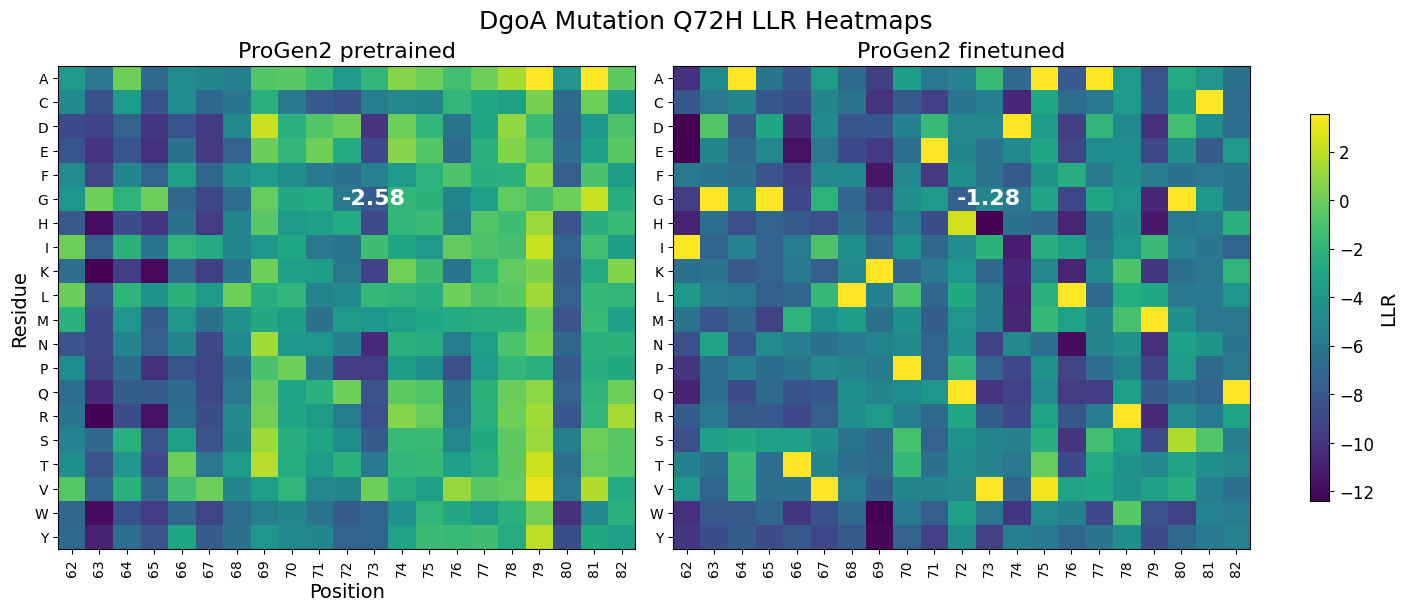

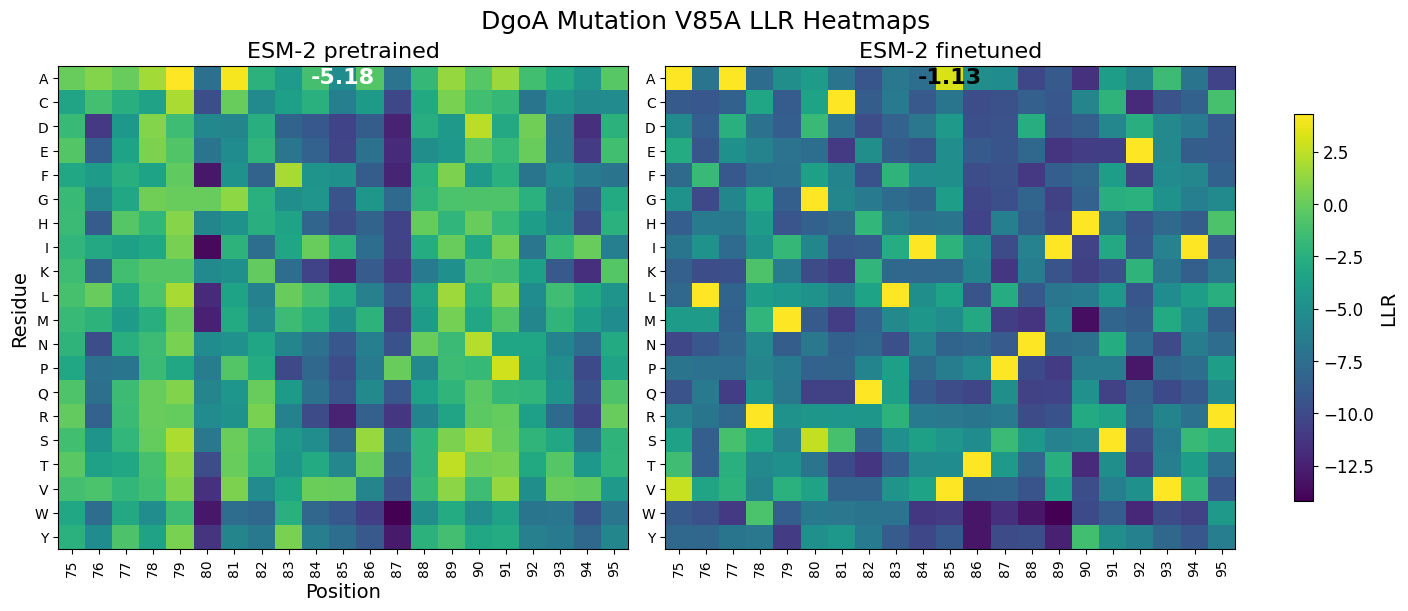

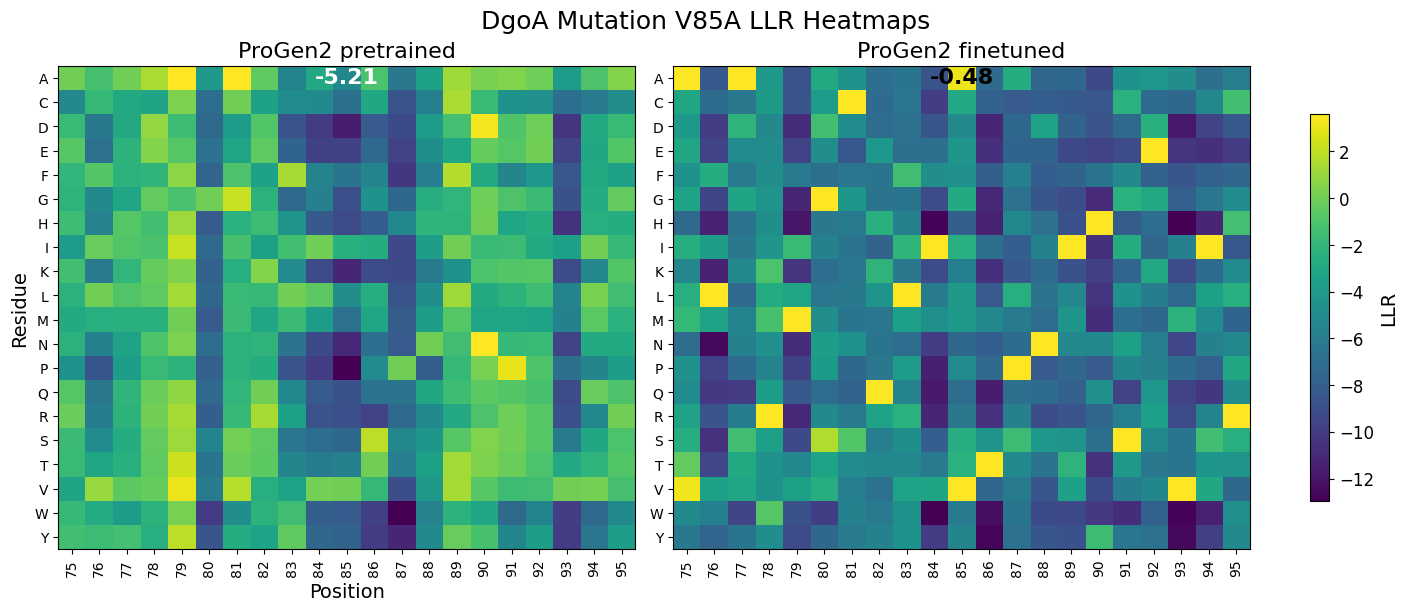

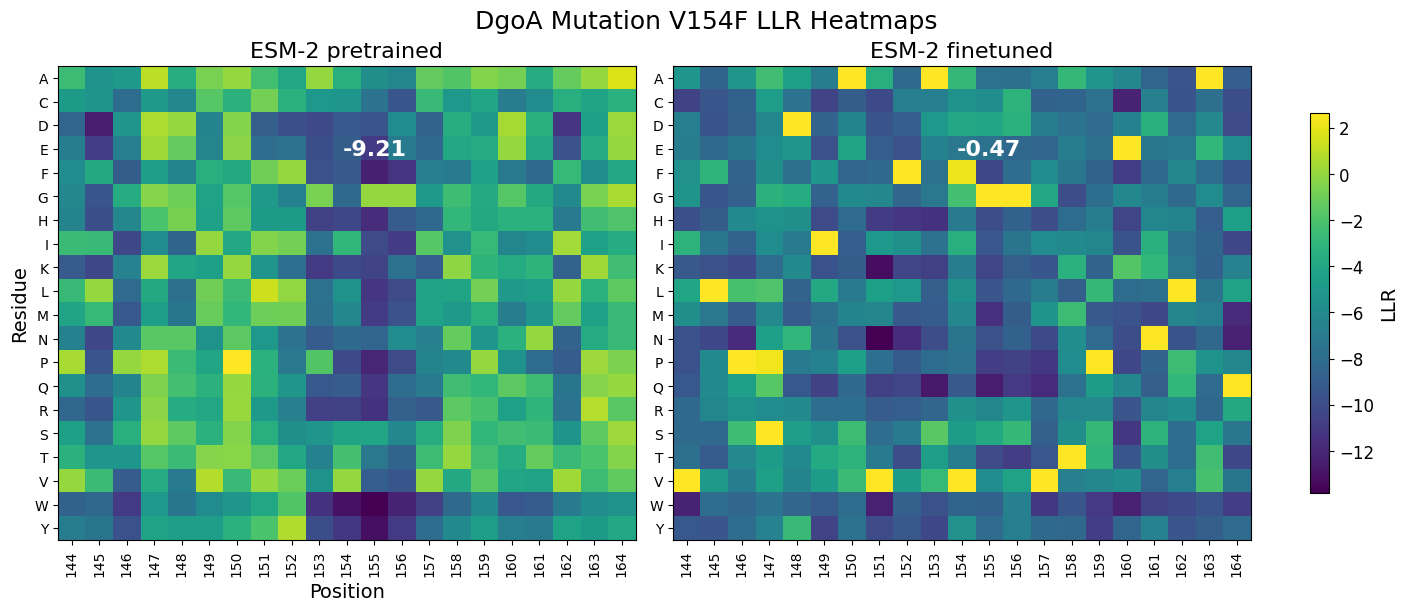

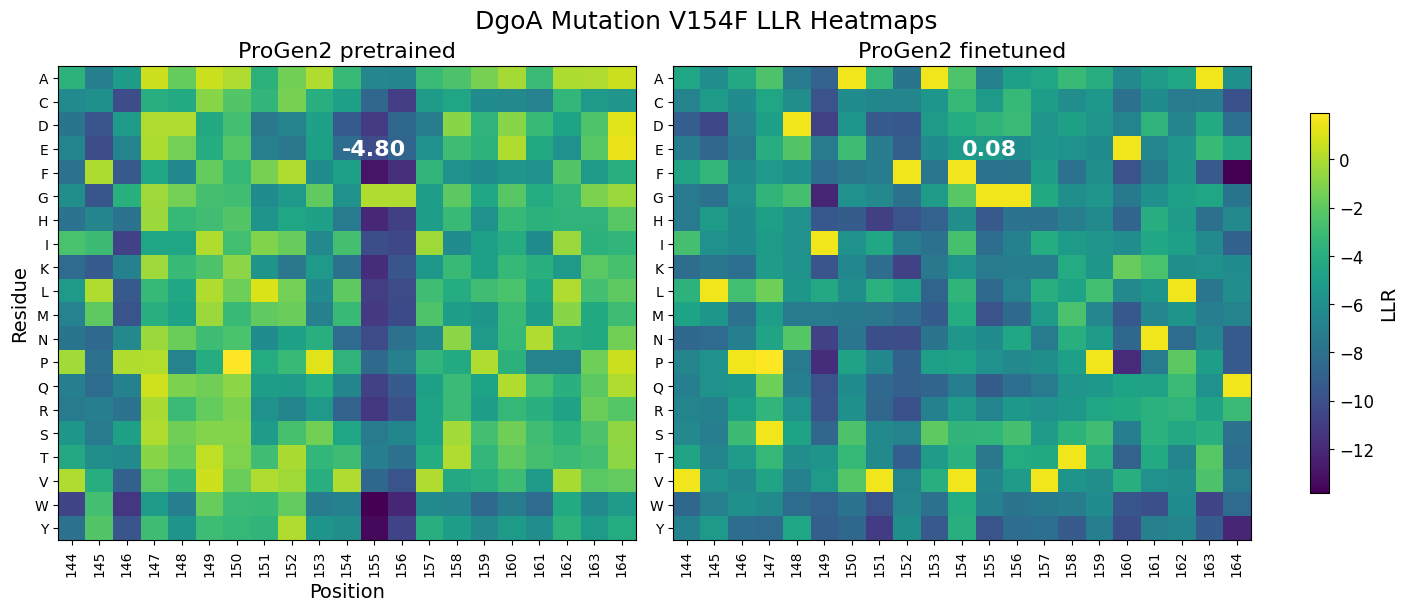

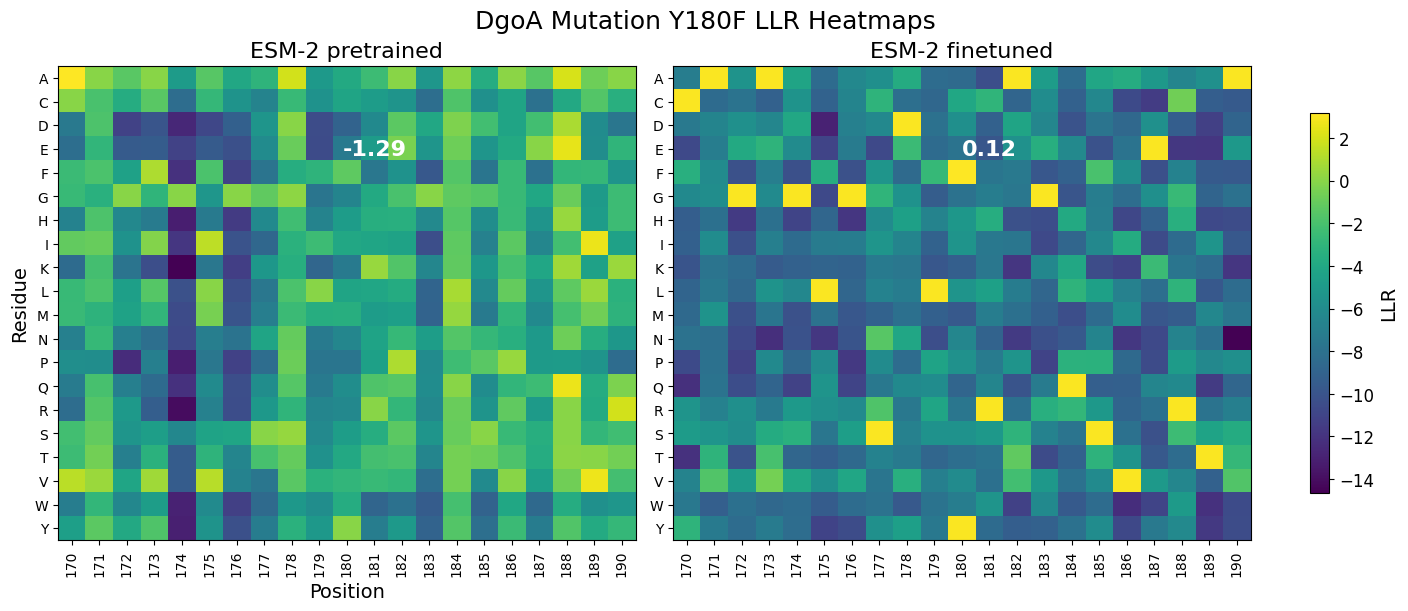

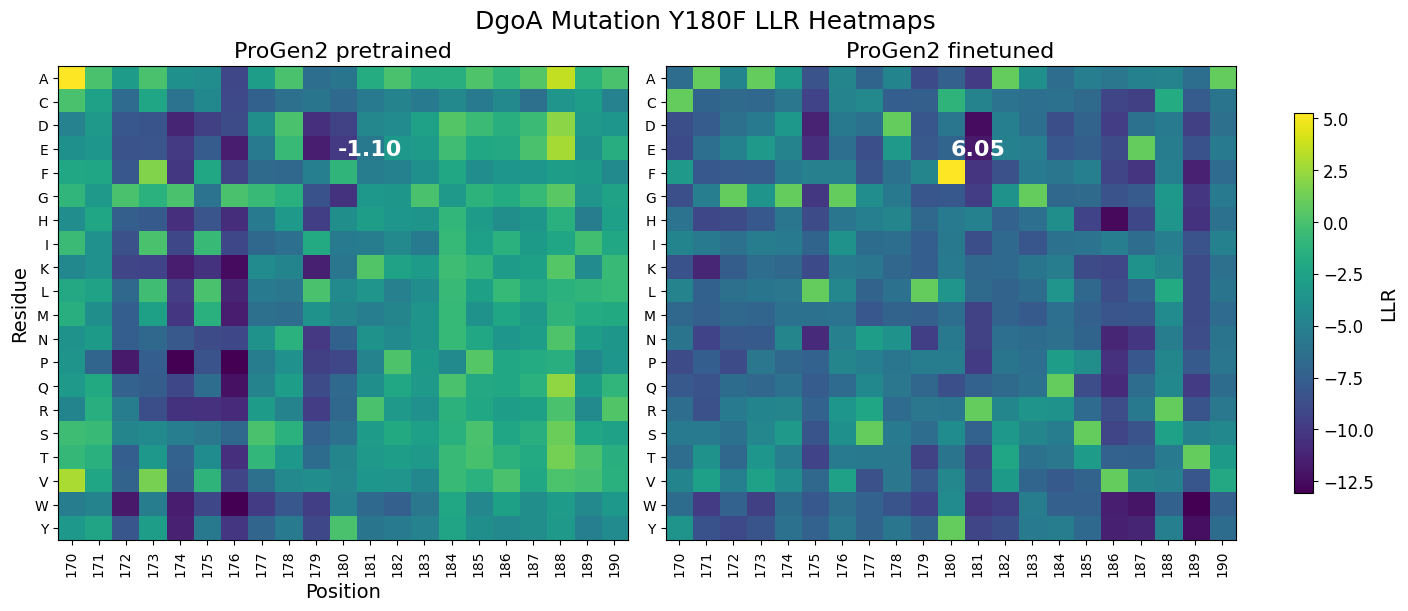

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Mapping from gene to its list of mutation strings
gene_mutation = {
    "DgoA": ["F33I", "D58N", "A75V", "Q72H", "V85A", "V154F", "Y180F"]
}
families = ["esm", "progen"]

def annotate_heatmap(ax, df, mutated_pos, mutated_residue,
                     window_size=10, cmap="viridis", offset_x=0.0, offset_y=0.0):
    cols = sorted(df.columns.astype(int))
    df = df[cols]
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    values = sub_df.values
    
    im = ax.imshow(values, aspect='auto', cmap=cmap)
    
    row_labels = sub_df.index.tolist()
    col_labels = sub_df.columns.tolist()
    i = row_labels.index(mutated_residue)
    j = col_labels.index(mutated_pos)
    
    cell_val = values[i, j]
    neighbor_val = values[i, j-1] if j > 0 else values[i, j+1]
    delta = cell_val - neighbor_val  # if you need it
    
    # pick a sample background for contrast
    samp_i = int(np.clip(i + offset_y, 0, values.shape[0]-1))
    samp_j = int(np.clip(j + offset_x, 0, values.shape[1]-1))
    samp_val = values[samp_i, samp_j]
    norm = Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
    rgba = plt.get_cmap(cmap)(norm(samp_val))
    lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
    text_color = 'white' if lum < 0.5 else 'black'
    
    ax.text(j + offset_x, i + offset_y,
            f"{cell_val:.2f}",
            ha='center', va='center',
            fontsize=16, fontweight='bold',
            color=text_color)
    
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=10)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=10)
    
    return im

# define custom offsets for any mutation that needs them
custom_offsets = {
    "V85A": (0, -0.05),   # example: (offset_x, offset_y) for V85A
    # you can add more: "F33I": (1,1), etc.
}

for gene, mutation_list in gene_mutation.items():
    for mut in mutation_list:
        pos = int(mut[1:-1])
        res = mut[-1]

        # choose offsets: custom if available, otherwise default
        offset_x, offset_y = custom_offsets.get(mut, (1, -1))
        
        for fam in families:
            pre_file = f"{gene}_{fam}_pretrained_full_sequence.csv"
            fin_file = f"{gene}_{fam}_finetuned_full_sequence.csv"
            if not (os.path.exists(pre_file) and os.path.exists(fin_file)):
                print(f"Skipping {gene} {mut} {fam}: missing files.")
                continue

            df_pre = pd.read_csv(pre_file, index_col=0)
            df_pre.columns = df_pre.columns.astype(int)
            df_pre = df_pre.sort_index(axis=1)

            df_fin = pd.read_csv(fin_file, index_col=0)
            df_fin.columns = df_fin.columns.astype(int)
            df_fin = df_fin.sort_index(axis=1)

            fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
            model_type = "ESM‑2" if fam=="esm" else "ProGen2"

            # Pretrained
            im = annotate_heatmap(
                axes[0], df_pre, pos, res,
                window_size=10, cmap="viridis",
                offset_x=offset_x, offset_y=offset_y
            )
            axes[0].set_title(f"{model_type} pretrained", fontsize=16)
            axes[0].set_xlabel("Position", fontsize=14)
            axes[0].set_ylabel("Residue", fontsize=14)

            # Finetuned
            annotate_heatmap(
                axes[1], df_fin, pos, res,
                window_size=10, cmap="viridis",
                offset_x=offset_x, offset_y=offset_y
            )
            axes[1].set_title(f"{model_type} finetuned", fontsize=16)

            plt.suptitle(f"{gene} Mutation {mut} LLR Heatmaps", fontsize=18)
            cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
            cbar.ax.tick_params(labelsize=12)
            cbar.set_label("LLR", fontsize=14)

            plt.savefig(f"{gene}_{fam}_mutation_{mut}_comparison.png", dpi=300)
            plt.show()
            plt.close(fig)





In [15]:
import glob
import pandas as pd
import numpy as np

# your mutations per gene
gene_mutation = {
    "DgoA": ["F33I", "D58N", "A75V", "Q72H", "V85A", "V154F", "Y180F"]
}

records = []

for path in glob.glob("*_full_sequence.csv"):
    # Expect filenames like "DgoA_esm_pretrained_full_sequence.csv"
    parts = path.replace(".csv", "").split("_")
    if len(parts) < 4:
        continue
    gene, family, status = parts[0], parts[1], parts[2]

    # get the list of mutations for this gene (if any)
    mutation_list = gene_mutation.get(gene, [])
    if not mutation_list:
        continue

    # load and prepare the DataFrame
    df = pd.read_csv(path, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)

    # for each mutation in the list, extract the LLR and neighbor delta
    for mut in mutation_list:
        pos = int(mut[1:-1])
        res = mut[-1]

        # LLR at the mutation
        cell_val = df.at[res, pos]

        # neighbor (left if possible, else right)
        cols = list(df.columns)
        j = cols.index(pos)
        if j > 0:
            neighbor_val = df.iloc[df.index.get_loc(res), j - 1]
        else:
            neighbor_val = df.iloc[df.index.get_loc(res), j + 1]
        delta = cell_val - neighbor_val

        annotated = f"{cell_val:.2f} / Δ{delta:.2f}"
        model_label = f"{family.upper()} {status}"

        records.append({
            "Gene":      gene,
            "Mutation":  mut,
            "Model":     model_label,
            "Annotated": annotated
        })

# build a DataFrame and print as markdown
table = pd.DataFrame(records, columns=["Gene", "Mutation", "Model", "Annotated"])
print(table.to_markdown(index=False))


| Gene   | Mutation   | Model             | Annotated      |
|:-------|:-----------|:------------------|:---------------|
| DgoA   | F33I       | ESM pretrained    | 1.24 / Δ14.62  |
| DgoA   | D58N       | ESM pretrained    | -3.14 / Δ3.03  |
| DgoA   | A75V       | ESM pretrained    | -1.26 / Δ3.95  |
| DgoA   | Q72H       | ESM pretrained    | -1.22 / Δ2.51  |
| DgoA   | V85A       | ESM pretrained    | -5.18 / Δ-4.03 |
| DgoA   | V154F      | ESM pretrained    | -9.21 / Δ0.46  |
| DgoA   | Y180F      | ESM pretrained    | -1.29 / Δ1.76  |
| DgoA   | F33I       | ESM finetuned     | -1.03 / Δ11.18 |
| DgoA   | D58N       | ESM finetuned     | -1.45 / Δ11.03 |
| DgoA   | A75V       | ESM finetuned     | -1.59 / Δ8.35  |
| DgoA   | Q72H       | ESM finetuned     | -0.84 / Δ12.24 |
| DgoA   | V85A       | ESM finetuned     | -1.13 / Δ10.83 |
| DgoA   | V154F      | ESM finetuned     | -0.47 / Δ11.33 |
| DgoA   | Y180F      | ESM finetuned     | 0.12 / Δ6.32   |
| DgoA   | F33I       | 